In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lstm-bax/df_bax_cleaned_to_view_outliers.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
from sklearn.metrics import mean_squared_error

2025-08-08 05:42:58.565815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754631778.742756      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754631778.791873      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
# --- Step 1: Load and Prepare Data ---

# Load the dataset from the CSV file
df = pd.read_csv('/kaggle/input/lstm-bax/df_bax_cleaned_to_view_outliers.csv')

# Convert the 'Date' column to datetime objects and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create a new dataframe with only the 'Price' column
data = df.filter(['Price'])

# Convert the dataframe to a numpy array
dataset = data.values

# Determine the training data length (e.g., 80% of the data)
training_data_len = math.ceil(len(dataset) * .8)

In [12]:
# --- Step 2: Scale the Data ---

# Scale the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [13]:
# --- Step 3: Create Training Dataset and Sequences ---

# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
time_step = 60 # Number of past days to use for prediction

for i in range(time_step, len(train_data)):
    x_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data to be 3D [samples, time steps, features] for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
# --- Step 4: Build and Train the LSTM Model ---

from tensorflow.keras.callbacks import EarlyStopping

# Build the more complex model
model = Sequential()
model.add(LSTM(75, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) # It's wise to keep dropout
model.add(LSTM(75, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the EarlyStopping callback
# This will stop training if the validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train with more epochs and the early stopping callback
print("Training the updated LSTM model...")
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=100, # Set a high number, EarlyStopping will find the best point
                    validation_split=0.2,
                    callbacks=[early_stop]) # Add the callback here

print("Model training complete.")

Training the updated LSTM model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0119 - val_loss: 0.0012
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6247e-04 - val_loss: 0.0013
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0862e-04 - val_loss: 9.8102e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4629e-04 - val_loss: 9.0002e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8203e-04 - val_loss: 8.6717e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7831e-04 - val_loss: 6.7090e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6403e-04 - val_loss: 6.9369e-04
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4942e-04 - val_loss: 9.1580e-04
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7778e-04 - val_loss: 5.1613e-04
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6269e-04 - val_loss: 0.0012
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6848e-04 - val_loss: 4.8357e-04


In [15]:
# --- Step 5: Create Test Dataset and Make Predictions ---

# Create the testing data set
test_data = scaled_data[training_data_len - time_step:, :]

# Create the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len:, :] # Actual values for comparison

for i in range(time_step, len(test_data)):
    x_test.append(test_data[i-time_step:i, 0])

# Convert the data to a numpy array and reshape it
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)

# Inverse transform the predictions to get the actual price values back
predictions = scaler.inverse_transform(predictions)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step



Root Mean Squared Error (RMSE): 15.286545680019106


/tmp/ipykernel_36/1993839136.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


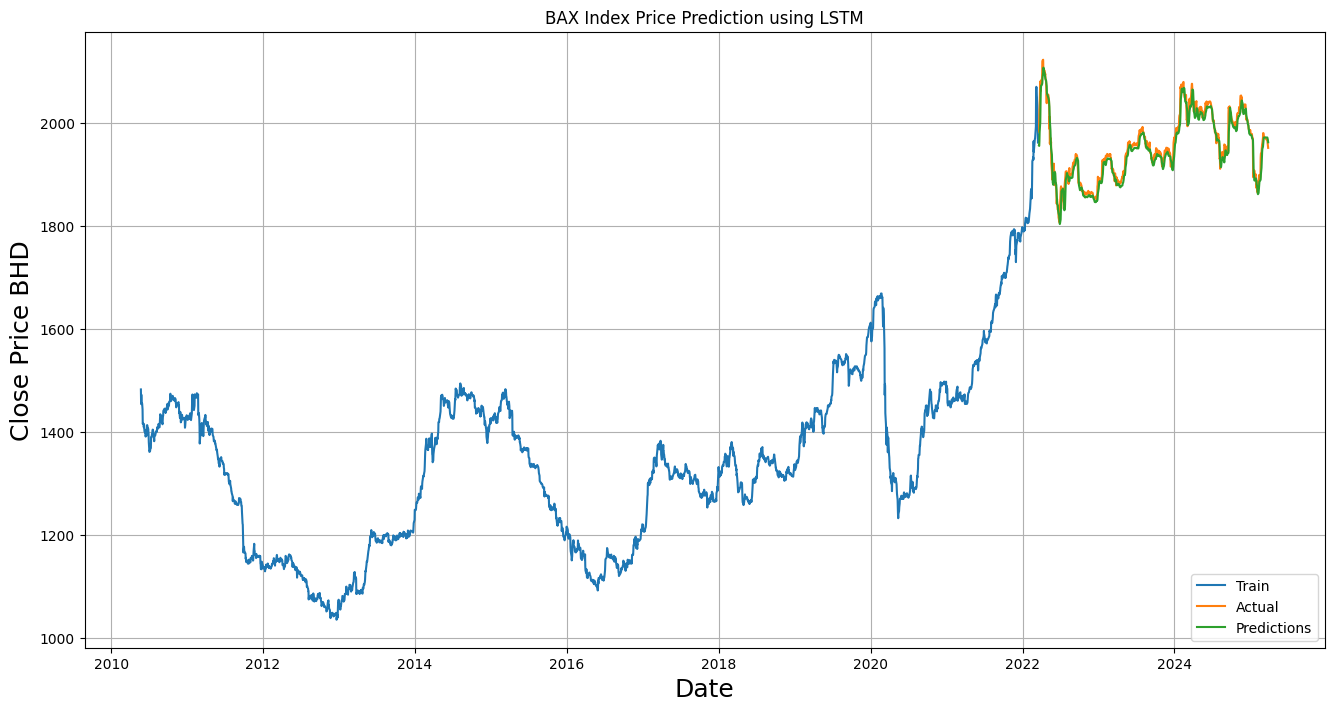

In [16]:
# --- Step 6: Evaluate the Model and Visualize Results ---

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'\nRoot Mean Squared Error (RMSE): {rmse}')

# Plot the data for visualization
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('BAX Index Price Prediction using LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price BHD', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.grid(True)
plt.show()

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0455e-04 - val_loss: 1.2030e-04
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0992e-04 - val_loss: 1.2670e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0305e-04 - val_loss: 1.1797e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1523e-04 - val_loss: 1.1251e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0187e-04 - val_loss: 1.3330e-04
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1311e-04 - val_loss: 9.8034e-05
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1839e-04 - val_loss: 1.0004e-04
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4754e-05 - val_loss: 2.6873e-04
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1057e-04 - val_loss: 2.9418e-04
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1472e-04 - val_loss: 3.5205e-04
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1975e-0

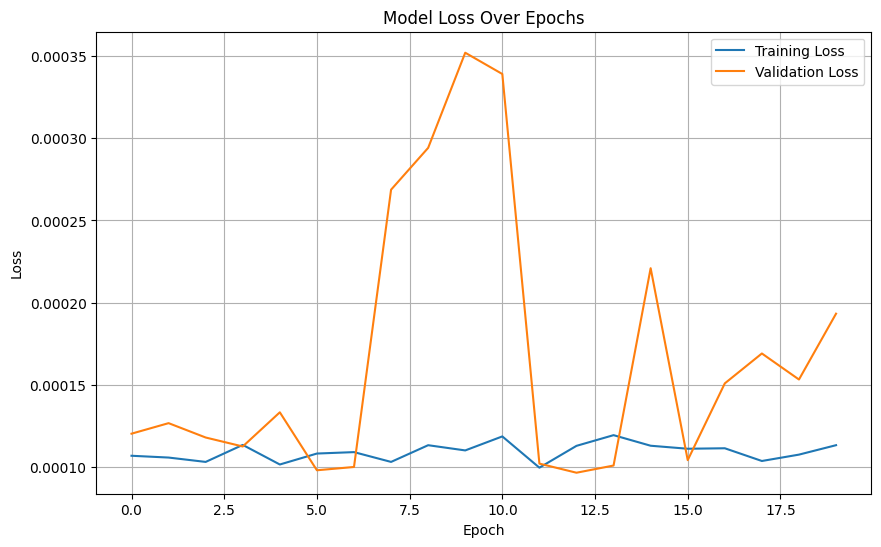

In [20]:
# Add validation_split to the fit method and store the training history
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=20,        # You might need more epochs to see the effect
                    validation_split=0.2) # Use 20% of training data for validation

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()